# Spectre 5x5

Ce notebook cherche à faire une première analyse sur la signature des classes :
- Chondre type I
- Chodre type II
- Mesostase type I
- Matrix
- Metals

On se base uniquement sur 6 features : Ca, Al, BSE, Mg, Si, Fe. L'Oxygène et le Souffre ne rajoutant pas d'information utile pour ces classes.

On prend un point de chaque classe et on calcul un vecteur de feature en prenant la moyenne sur une zone 5x5 autour du point.

On cherche ensuite à faire une segmentation type KMeans : nos points sont nos centroïdes de chaque classe et pour chaque point de l'image on regarde le centroïdes le plus proche au sens de la distance euclidienne.

**Resultat** : les classes sont mélangés, un seul représentant est trop insuffisant, le souffre et l'oxygène peuvent être intéressant à ajouter et peut être même d'autres features, une moyenne sur 5x5 ne donne pas suffisament d'information sur la localité.

---

# Chargement des données

On charge seulement une fraction de l'image

In [12]:
from src.utils import *
import ipywidgets as widgets
from ipywidgets import interact
from matplotlib.patches import Rectangle
from sklearn.metrics.pairwise import cosine_similarity

In [9]:
x = 4950
y = 1700
width = 1500
height = 1000

files = ["Ca", "Al", "Mg", "BSE", "Si", "Fe"]
imgs = load_images(x, y, width, height, files)

On organise nos images en un tenseur de taille `(width, height, depth)` où `depth` correspond au nombre de features.

In [10]:
mat_imgs = list(imgs.values())

cubes = np.array(mat_imgs)
print(cubes.shape)

cubes = np.moveaxis(cubes, 0, -1)
print(cubes.shape)

dim = cubes.shape[-1]
print(dim)

(6, 1000, 1500)
(1000, 1500, 6)
6


---

# Extraction et visualisation des classes

On extrait nos points représentatif de nos classes.

In [24]:
# (X, Y)
base = [
    (143, 771),  # type I
    (1247, 700), # type II
    (195, 771),  # mesostase I
    (114, 53),   # Matrix
    (230, 380)   # Metals
]

# Type II vs Matrix juste pour la visualisation
abase = [
    (1247, 700),
    (1285, 470),
    (500, 370),
    (1260, 980),
    (114, 53),
    (1400, 200),
    (1470, 470),
    (980, 700),
]

On affiche sur la carte BSE pour avoir une meilleure idée :

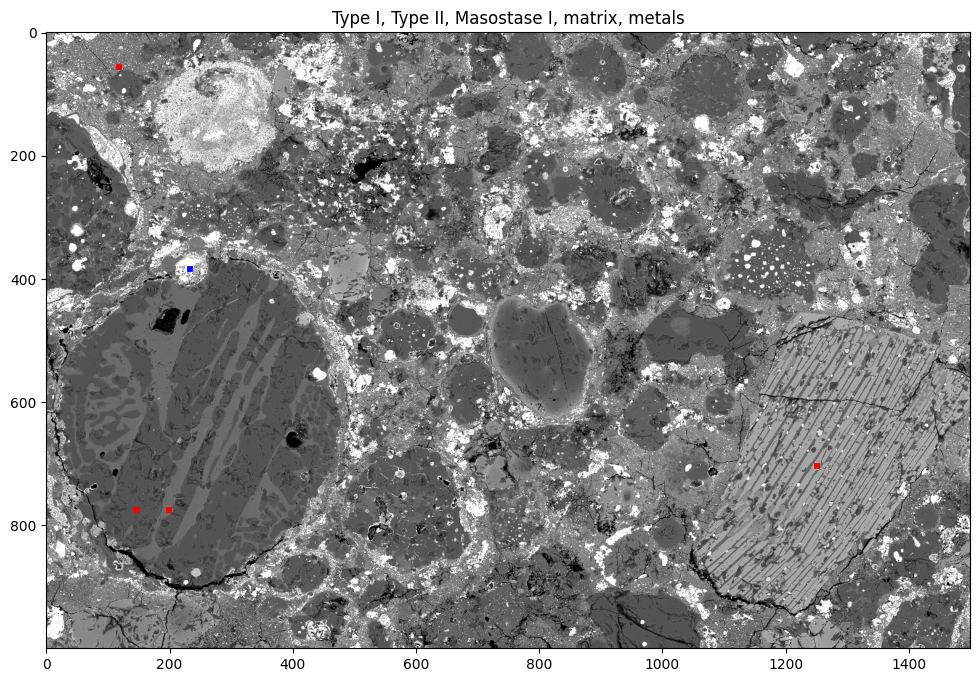

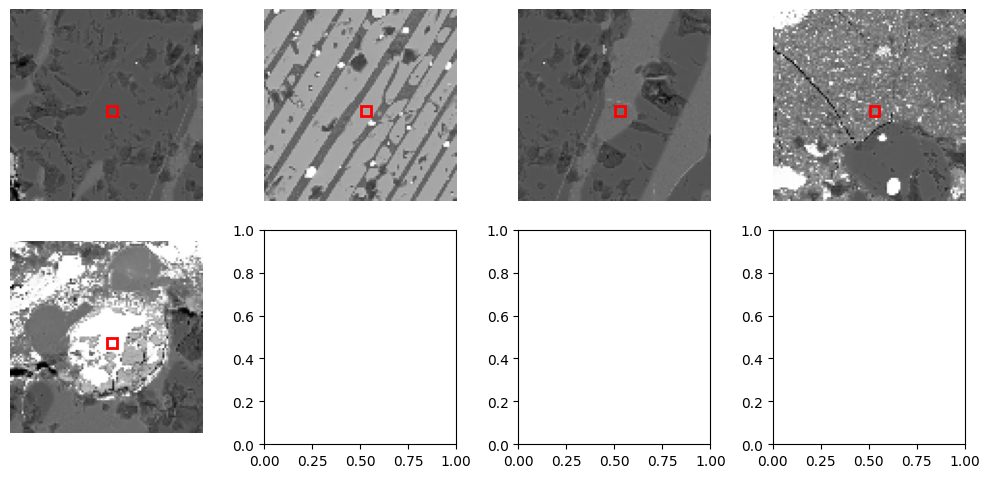

In [28]:
def plot_classes(base, title):
    bse = imgs["BSE"]
    
    window = 50
    ker_size = 5
    
    plt.figure(figsize=(12,8))
    plt.imshow(bse, cmap="grey")
    
    colors = "rrrrbbbb"
    
    for (i, (x,y)) in enumerate(base):
        plt.gca().add_patch(Rectangle((x,y),ker_size,ker_size,linewidth=2,edgecolor=colors[i],facecolor='none'))
    
    plt.title(title)
    plt.show()
    
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    ax = axes.flatten()
    
    for (i, (x,y)) in enumerate(base):
        ax[i].imshow(bse[y-window:y+window,x-window:x+window], cmap="grey", vmin=0, vmax=255)
        ax[i].set_axis_off()
        ax[i].add_patch(Rectangle((window,window),ker_size,ker_size,linewidth=2,edgecolor='r',facecolor='none'))
    
    fig.tight_layout()
    plt.show()

plot_classes(base, "Type I, Type II, Masostase I, matrix, metals")

---

# Comparaison des classes

On plot la signature de chaque classes.

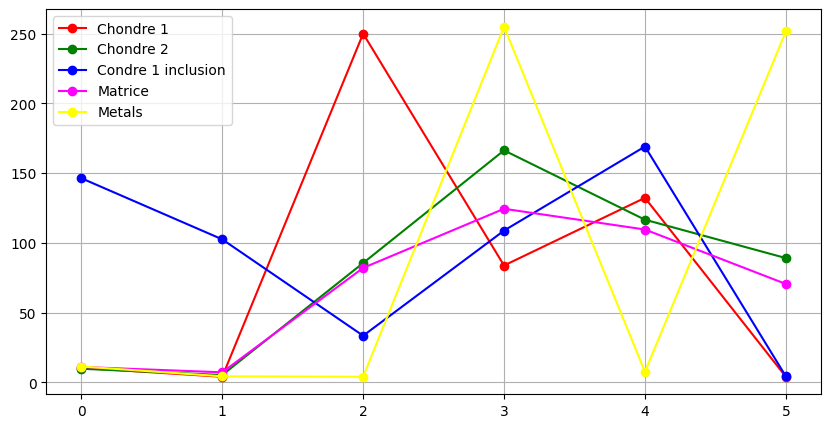

In [33]:
plt.figure(figsize=(10, 5))
window = 0
window_size = 5

X = []
colors = ["red", "green", "blue", "magenta", "yellow", "cyan"]
labels = ["Chondre 1", "Chondre 2", "Condre 1 inclusion", "Matrice", "Metals", ""]
for xd in range(-window, window + 1):
    for yd in range(-window, window + 1):
        for (i, (x,y)) in enumerate(base):
            xx = x + xd * 2
            yy = y + yd * 2
    
            datas = cubes[yy:yy+window_size,xx:xx+window_size,:]
            datas = datas.mean(axis=(0,1))

            if xd == 0 and yd == 0:
                X.append(np.array(datas))
    
            plt.plot(range(dim), datas, marker='o', color=colors[i], label=labels[i])
            continue
            color = "red"
            if i > 3:
                color = "blue"
            plt.plot(range(dim), datas, marker='o', color=color)

plt.legend()
plt.grid()
plt.show()

---

# Distance cosine

On définit nos points comme étant les centroïdes et on calcul la cosine similarity sur l'image entière et on attribut chaque pixel à la classes avec la plus grande similarité.

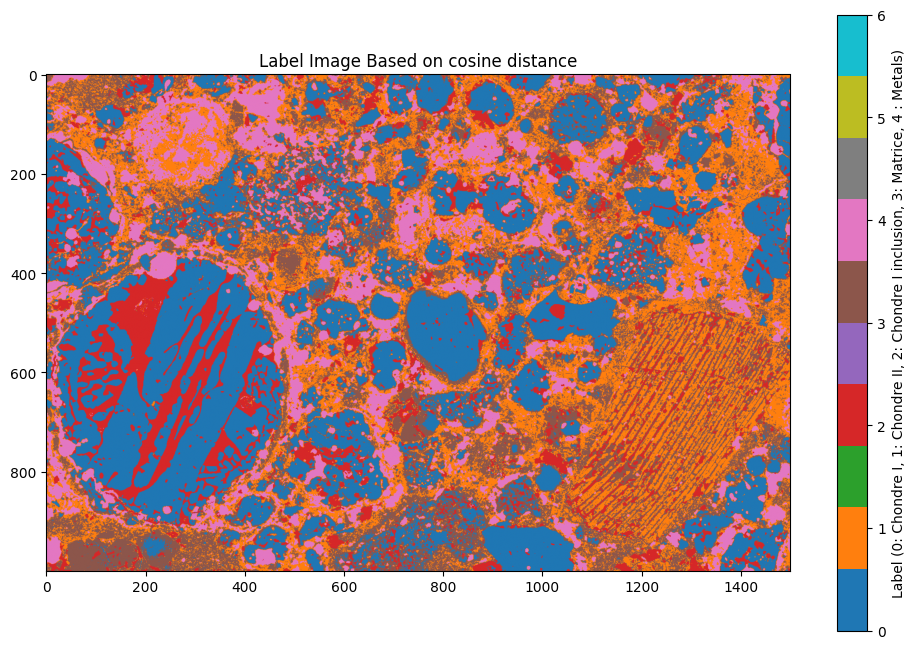

In [39]:
A = np.array(X).T
pixels = cubes.reshape(-1, dim)

output = np.zeros(pixels.shape)

similarities = cosine_similarity(pixels, A.T)

best_match = np.argmax(similarities, axis=1)
best_similarity = np.max(similarities, axis=1)

output = best_match.reshape(cubes.shape[0], cubes.shape[1])

plt.figure(figsize=(12,8))
plt.imshow(output, cmap='tab10', vmin=0, vmax=6)
plt.colorbar(label="Label (0: Chondre I, 1: Chondre II, 2: Chondre I inclusion, 3: Matrice, 4 : Metals)")
plt.title("Label Image Based on cosine distance")
plt.show()